In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [15]:
def get_sounding(path_string, trend):
    '''Takes the path to the text file and + or - trend value based on upward or downward aircraft profile and 
       return a list of different pandas dataframes with ascent or descent sounding data.
       (Automatically drops the rows with NaN values for theta and altitude)'''
    
    df = pd.read_csv (path_string, dtype='float', na_values = '-999999')
    derivative = df['GPS_ALT'].diff(periods=60) / df['UTC'].diff(periods=60) 
    df['trend'] = derivative.gt(0).map({False: -1, True: 1})
    
    if trend >= 0:
        
        '''Flight observations while the plane is going up == Difference in altitude for subsequnt points is always poistive.
           So, the difference will be negative whenever the plane starts to come down.
           Divide the dataset according to indices when the plane starts coming down'''
        
        idx = df.index[df['trend'] == 1].dropna()
        dataset_profile = df.loc[idx].dropna(subset=['GPS_ALT', 'THETA'])
        reqd_Index = np.where(dataset_profile['GPS_ALT'].diff() < -1.0)
        
    else:
        
        '''Flight observations while the plane is coming down == Difference in altitude for subsequnt points is always negative.
           Divide the dataset according to indices when the plane starts going up and the difference becomes positive'''
        
        idx = df.index[df['trend'] == -1].dropna()
        dataset_profile = df.loc[idx].dropna(subset=['GPS_ALT', 'THETA'])
        reqd_Index = np.where(dataset_profile['GPS_ALT'].diff() > 1.0)
    
    final_index = np.asarray(reqd_Index[0])
    diff = np.diff(final_index)
    empty_array = np.arange(0,len(diff),1)
        
    df_list=[]
    i = 0
    for i in empty_array:
        start = final_index[i]
        end = diff[i]+start
        dfx = dataset_profile.iloc[start:end]
        df_new = dfx.sort_values(by=['GPS_ALT'], ignore_index=True)
        df_list.append(df_new)
    return df_list

Temperature Gradient Method(TGRD) Method. 
"The CTBL and CBL are generally capped by a well-defined temperature inversion with a substantial maximum in the lapse rate of potential temperature (Figs. 1 and 2). This property is used to identify h as the base of this enhanced inversion layer from a single sounding."

Refer to the Method No. 3.2 (Page 6 of 26) in the paper by 
[Dai et al., 2014](https://link.springer.com/content/pdf/10.1007/s10546-014-9929-z.pdf)



In [56]:
'''Determine Boundary Layer from Potential Temperature Gradient Method'''

def bl_grad(dataframe):
    "Takes the pandas dataframe for a particular sounding with altitude and theta values. Returns the PBL value in meters."
    
    alt = dataframe['GPS_ALT']*1000
    theta = dataframe['THETA']

    '''Calculate d(theta)/dz (A 7-point average has been taken as per the literature)'''
    derivative = theta.diff(periods = 7).dropna()/alt.diff(periods = 7).dropna()
    
    '''Calculate the altitude where maximum derivaive ooccurs'''
    alt_numpy = alt[7:]
    if len(derivative)>0:
        bl_value = alt_numpy[derivative.argmax()]
        return bl_value
    else:
        return None
    return bl_value

The vertical gradients in (1) can be approximated with finite differences using adjacent values of the smoothed profiles. It then becomes a bulk Richardson number. Refer to the Method No. 3.3 (Page 10 of 26) in the paper by 
[Dai et al., 2014](https://link.springer.com/content/pdf/10.1007/s10546-014-9929-z.pdf)


The Richardson method is a direct approach for estimating h in practical applications and is widely used in diagnosing h from mesoscale forecast models (Straume et al. 1998; Zilitinkevich and Baklanov 2002; Batchvarova and Gryning 2003; Jericˇevic ́ and Grisogono 2006).

In [57]:
'''Determination of BL via Bulk Richardson Number technique'''

def bl_richard(dataframe, threshold):
    
    '''Takes the pandas dataframe for a particular sounding and threshold value of Richardson number for PBL. 
       Returns the PBL value in meters.'''
    
    g = 9.8 #Gravitational Acceleration
    dataframe = dataframe.dropna(subset=['WND','TAS','THETA','GPS_ALT'])
    alt = dataframe['GPS_ALT']*1000
    
    '''Converting Meteorlogical wind direction to mathematical wind direction'''
    math_wd = 270 - dataframe["WND"]
    wind_dir = [math.radians(i) for i in math_wd]
    
    '''Finding u and v components of wind'''
    sin_wind = [math.sin(i) for i in wind_dir]
    cos_wind = [math.cos(i) for i in wind_dir]
    u = dataframe["TAS"]*(cos_wind)
    v = dataframe["TAS"]*(sin_wind)
    
    '''Calculating Bulk Richardson Number'''
    delta_u = u.diff()
    delta_v = v.diff()
    delta_theta = dataframe["THETA"].diff()
    delta_alt = dataframe["GPS_ALT"].diff()
    avg_theta = dataframe["THETA"].rolling(2).mean()
    richard_no = (g * delta_alt * delta_theta)/(avg_theta * (delta_u**2 + delta_v**2))
    richard_no = richard_no.dropna()
    
    '''Calculating the altitude index where Bulk Richardson number reaches the threshold''' 
    ind = np.where(richard_no > threshold)
    if len(ind[0])<1:
        return None
    else:
        alt = alt[1:].to_numpy()
        bl_value = alt[ind[0][0]]
    return bl_value



In [58]:
Up_sounding = get_sounding('Newfile_RF-04_DISCOVER-AQ', 1)
Down_sounding =get_sounding('Newfile_RF-04_DISCOVER-AQ', -1)

bl_theta_ascent =[]
bl_theta_descent = []
bl_richard_ascent = []
bl_richard_descent = []
bl_ascent_UTC = []


for dataframe in Up_sounding:
    bl_value0 = bl_grad(dataframe)
    bl_theta_ascent.append(bl_value0)
    bl_value1 = bl_richard(dataframe, 0.25)
    bl_richard_ascent.append(bl_value1)
    

for dataframe in Down_sounding:
    bl_value0 = bl_grad(dataframe)
    bl_theta_descent.append(bl_value0)
    bl_value1 = bl_richard(dataframe, 0.25)
    bl_richard_descent.append(bl_value1)
    

for dataframe in Up_sounding:
    time = pd.to_datetime(dataframe['UTC'],unit='s')
    tsp = time.median()
    bl_ascent_UTC.append(tsp)
    



In [59]:
bl_dictionary = {'bl_ascent_UTC':bl_ascent_UTC, 'bl_richard_ascent':bl_richard_ascent,'bl_theta_ascent':bl_theta_ascent}
bl_values = pd.DataFrame(bl_dictionary)
print(bl_values)
bl_values.to_csv(r'boundary_layer_values.txt', sep=' ')

            bl_ascent_UTC  bl_richard_ascent  bl_theta_ascent
0 1970-01-01 14:57:23.000             184.46           283.88
1 1970-01-01 15:41:34.500            4633.17          4630.91
2 1970-01-01 16:24:08.000            4002.85          4010.16
3 1970-01-01 17:01:22.000            4025.35          4015.88
4 1970-01-01 17:41:33.000            4350.74           307.73
5 1970-01-01 18:26:04.000            4386.32          4640.26
6 1970-01-01 19:07:55.000            3989.78          3979.68
7 1970-01-01 19:44:47.000             338.13           317.23
8 1970-01-01 20:24:23.500            4364.41           314.27
9 1970-01-01 21:09:12.500            4618.71          4687.66


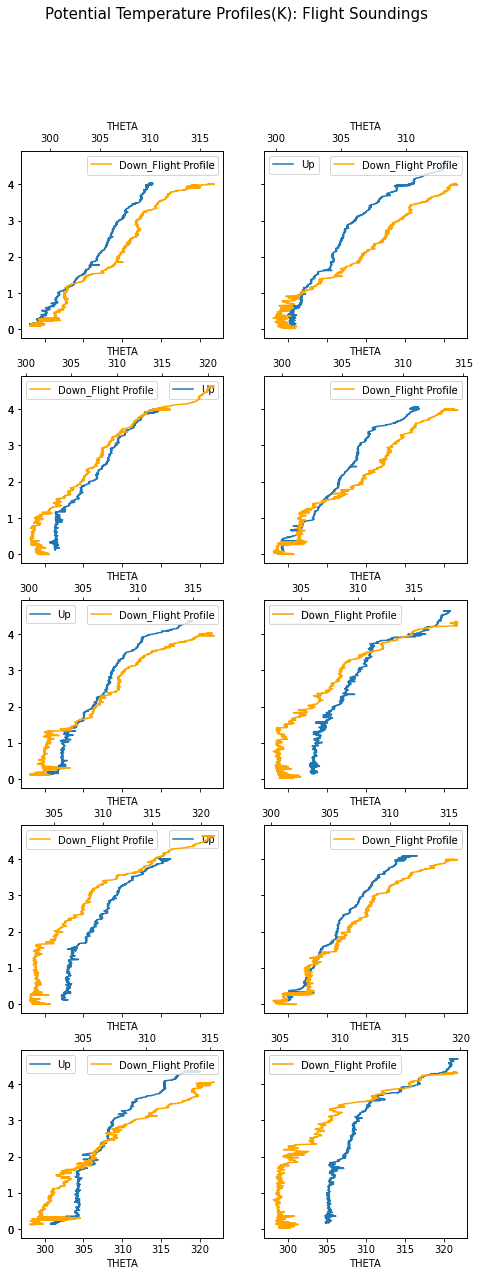

In [60]:
'''Final soundings and pbl values'''
nrow=5
ncol=2

fig, axes = plt.subplots(nrow, ncol, figsize = (8,20), sharex=True, sharey=True)
plt.suptitle('Potential Temperature Profiles(K): Flight Soundings', fontsize = 15)

count=0
for r in range(nrow):
    for c in range(ncol):
        ax1 = Up_sounding[count].plot(ax=axes[r,c],y = "GPS_ALT", x = "THETA", label="Up")
        ax2 = ax1.twiny()
        Down_sounding[count].plot(ax=ax2,y = "GPS_ALT", x = "THETA", color = 'orange', label="Down_Flight Profile")
        # plt.tick_params('x', labelbottom=False)
        count+=1
plt.legend()        
plt.show()


